## Calculate soil moisture-precipitation feedback

Author: Yifan Cheng

References: 

https://doi.org/10.1029/2020GL087779

In [3]:
import datetime
current_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
print(f'Last updated at {current_time}')

Last updated at 2025-05-16 09:51


In [1]:
from pathlib import Path 
import xarray as xr
import cartopy.crs as ccrs
import uxarray as ux
import numpy as np
import cartopy.feature as cf
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import intake
import seaborn as sns
import dask 
import os 
from dask_jobqueue import PBSCluster
from dask.distributed import Client
from dask.distributed import performance_report

## look for more variables in CONUS404 raw dataset

In [19]:
te=xr.open_dataset('/glade/campaign/collections/rda/data/d559000/wy2020/202008/wrf2d_d01_2020-08-31_18:00:00.nc')

In [23]:
var_longname_dict = {
    var: te[var].attrs.get("description", "N/A")
    for var in te.data_vars
}

In [2]:
scratch = os.environ.get("SCRATCH") or getuser()
print(scratch)

cat_url     = '/glade/campaign/collections/rda/data/d559000/catalogs/d559000_catalog.json'
print(cat_url)

/glade/derecho/scratch/yifanc17
/glade/campaign/collections/rda/data/d559000/catalogs/d559000_catalog.json


In [3]:
# Create a PBS cluster object
cluster = PBSCluster(
    job_name = 'wcrp-hackathon25',
    account= 'UCIS0005',
    cores = 1,
    memory = '10GiB',
    processes = 1,
    local_directory = scratch,
    log_directory = scratch,
    resource_spec = 'select=1:ncpus=1:mem=10GB',
    queue = 'casper',
    walltime = '5:00:00',
    interface = 'ext'
)

client = Client(cluster)

In [4]:
cluster.scale(5)

In [5]:
cluster

Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/yifanc17/Derecho/proxy/42763/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.192:46793,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/yifanc17/Derecho/proxy/42763/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [6]:
col = intake.open_esm_datastore(cat_url)
col

,unique
path,79
variable,206
format,1
short_name,206
long_name,118
units,32
start_time,41
end_time,41
level,0
level_units,0


In [7]:
# 'SMOIS': 'SOIL MOISTURE',
# 'PREC_ACC_NC': 'ACCUMULATED GRID SCALE  PRECIPITATION OVER prec_acc_dt PERIODS OF TIME',
cat_sm = col.search(variable='SMOIS')
cat_prcp = col.search(variable='PREC_ACC_NC')
cat_sm.df.head()

,path,variable,format,short_name,long_name,units,start_time,end_time,level,level_units,frequency
0,/glade/campaign/collections/rda/data/d559000/k...,SMOIS,reference,SMOIS,NaN,m3 m-3,1979-10-01,1980-09-30 23:00:00,NaN,NaN,0 days 01:00:00
1,/glade/campaign/collections/rda/data/d559000/k...,SMOIS,reference,SMOIS,NaN,m3 m-3,1980-10-01,1981-09-30 23:00:00,NaN,NaN,0 days 01:00:00
2,/glade/campaign/collections/rda/data/d559000/k...,SMOIS,reference,SMOIS,NaN,m3 m-3,1981-10-01,1982-09-30 23:00:00,NaN,NaN,0 days 01:00:00
3,/glade/campaign/collections/rda/data/d559000/k...,SMOIS,reference,SMOIS,NaN,m3 m-3,1982-10-01,1983-09-30 23:00:00,NaN,NaN,0 days 01:00:00
4,/glade/campaign/collections/rda/data/d559000/k...,SMOIS,reference,SMOIS,NaN,m3 m-3,1983-10-01,1984-09-30 23:00:00,NaN,NaN,0 days 01:00:00


In [8]:
year = 2019 #load in 2020 JJA data to check

date = str(year)+ "-10-01" # this always needs to be the start month and day of the water year
cat_sm_subset = cat_sm.search(start_time = date)
cat_prcp_subset = cat_prcp.search(start_time = date)
cat_sm_subset

,unique
path,1
variable,1
format,1
short_name,1
long_name,0
units,1
start_time,1
end_time,1
level,0
level_units,0


In [9]:
%%time 

# Load catalog entries for subset into a dictionary of xarray datasets, and open the first one.
dsets_sm = cat_sm_subset.to_dataset_dict(zarr_kwargs={"consolidated": True})
dsets_prcp = cat_prcp_subset.to_dataset_dict(zarr_kwargs={"consolidated": True})
print(f"\nDataset dictionary keys:\n {dsets_prcp.keys()}")


--> The keys in the returned dictionary of datasets are constructed as follows:
	'variable.short_name'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'variable.short_name'



Dataset dictionary keys:
 dict_keys(['PREC_ACC_NC.PREC_ACC_NC'])
CPU times: user 31.8 s, sys: 2.99 s, total: 34.8 s
Wall time: 3min 5s


In [10]:
year = 2020 #load in 2020 DJF data to check

date = str(year)+ "-10-01" # this always needs to be the start month and day of the water year
cat_sm_subset2 = cat_sm.search(start_time = date)
cat_prcp_subset2 = cat_prcp.search(start_time = date)

In [11]:
%%time 

# Load catalog entries for subset into a dictionary of xarray datasets, and open the first one.
dsets_sm2 = cat_sm_subset2.to_dataset_dict(zarr_kwargs={"consolidated": True})
dsets_prcp2 = cat_prcp_subset2.to_dataset_dict(zarr_kwargs={"consolidated": True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'variable.short_name'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'variable.short_name'


CPU times: user 29.8 s, sys: 2.76 s, total: 32.6 s
Wall time: 1min 27s


In [12]:
dataset_key_sm = list(dsets_sm.keys())[0]
dataset_key_prcp = list(dsets_prcp.keys())[0]

In [13]:
ds_sm = dsets_sm[dataset_key_sm]['SMOIS']
ds_prcp = dsets_prcp[dataset_key_prcp]['PREC_ACC_NC']

In [14]:
ds_sm2 = dsets_sm2[dataset_key_sm]['SMOIS']
ds_prcp2 = dsets_prcp2[dataset_key_prcp]['PREC_ACC_NC']

In [15]:
%%time 
# 2020 JJA
start_date = "2020-06-01T00"
end_date = "2020-08-31T00"
prcp_monthly_data = ds_prcp.sel(Time=slice(start_date, end_date))
sm_monthly_data = ds_sm.sel(Time=slice(start_date, end_date))

CPU times: user 3.39 s, sys: 17.3 ms, total: 3.4 s
Wall time: 3.8 s


In [16]:
# 2020 DJF
start_date = "2020-12-01T00"
end_date = "2021-02-28T00"
prcp_monthly_data2 = ds_prcp2.sel(Time=slice(start_date, end_date))
sm_monthly_data2 = ds_sm2.sel(Time=slice(start_date, end_date))

In [17]:
prcp_daily_2020_JJA=prcp_monthly_data.resample(Time='1D').mean()
sm_daily_2020_JJA=sm_monthly_data.resample(Time='1D').mean()

In [18]:
prcp_daily_2020_DJF=prcp_monthly_data2.resample(Time='1D').mean()
sm_daily_2020_DJF=sm_monthly_data2.resample(Time='1D').mean()

In [19]:
prcp_daily_2020_DJF

<xarray.DataArray 'PREC_ACC_NC' (Time: 90, south_north: 1015, west_east: 1367)> Size: 500MB
dask.array<transpose, shape=(90, 1015, 1367), dtype=float32, chunksize=(1, 882, 1188), chunktype=numpy.ndarray>
Coordinates:
  * Time     (Time) datetime64[ns] 720B 2020-12-01 2020-12-02 ... 2021-02-28
Dimensions without coordinates: south_north, west_east
Attributes:
    description:  ACCUMULATED GRID SCALE  PRECIPITATION OVER prec_acc_dt PERI...
    long_name:    Accumulated grid scale  precipitation , accumulated over pr...
    stagger:       
    units:        mm

In [35]:
def compute_sm_precip_feedback_anomaly(daily_sm, daily_pr, sm_thresholds=(-1.0, 1.0), lead_lag_days=1):
    clim_mean = daily_sm.mean('Time')
    clim_std = daily_sm.std("Time")
    sm_anom = daily_sm - clim_mean
    #sm_std_anom = sm_anom / clim_std

    sm_flat = sm_anom.stack(z=daily_sm.dims[1:])
    pr_flat = daily_pr.stack(z=daily_pr.dims[1:])

    no_rain_on_sm_day = pr_flat <= 0.01

    dry_mask = (sm_flat < sm_thresholds[0]) & no_rain_on_sm_day
    wet_mask = (sm_flat > sm_thresholds[1]) & no_rain_on_sm_day

    pr_shifted = pr_flat.shift(Time=-lead_lag_days)

    pr_after_dry = pr_shifted.where(dry_mask).mean(dim='Time')
    pr_after_wet = pr_shifted.where(wet_mask).mean(dim='Time')

    feedback_index = pr_after_wet - pr_after_dry
    feedback_index.name = "sm_precip_feedback_anom"

    feedback_index = feedback_index.unstack('z')

    return feedback_index

In [41]:
def compute_sm_precip_feedback_conditional(daily_sm, daily_pr, sm_thresholds=(0.0, 0.0), pr_thresh=0.1, lead_lag_days=1):
    clim_mean = daily_sm.mean('Time')
    clim_std = daily_sm.std("Time")
    sm_anom = daily_sm - clim_mean
    sm_std_anom = sm_anom / clim_std

    sm_flat = sm_anom.stack(z=daily_sm.dims[1:])
    pr_flat = daily_pr.stack(z=daily_pr.dims[1:])
    
    # Shift precipitation to align with rain *after* SM
    pr_shifted = pr_flat.shift(Time=-lead_lag_days)

    no_rain_on_sm_day = pr_flat <= 0.01

    dry_mask = (sm_flat < sm_thresholds[0]) & no_rain_on_sm_day
    wet_mask = (sm_flat > sm_thresholds[1]) & no_rain_on_sm_day

    # dry_mask = sm_flat < sm_thresholds[0]
    # wet_mask = sm_flat > sm_thresholds[1]

    rain_mask = pr_shifted > pr_thresh

    p_rain_dry = rain_mask.where(dry_mask).sum("Time") / dry_mask.sum("Time")
    p_rain_wet = rain_mask.where(wet_mask).sum("Time") / wet_mask.sum("Time")

    # Feedback index: P(rain|wet) - P(rain|dry)
    feedback = p_rain_wet - p_rain_dry
    feedback.name = "sm_precip_feedback_prob"

    feedback_index = feedback.unstack('z')

    return feedback_index

In [38]:
%%time
FI_mag_JJA=compute_sm_precip_feedback_anomaly(sm_daily_2020_JJA.sel(soil_layers_stag=0), 
                                      prcp_daily_2020_JJA, sm_thresholds=(0.0,0.0), lead_lag_days=1).compute()

CPU times: user 1min 29s, sys: 5.17 s, total: 1min 34s
Wall time: 7min 45s


In [37]:
%%time
FI_prob_JJA=compute_sm_precip_feedback_conditional(sm_daily_2020_JJA.sel(soil_layers_stag=0), 
                                               prcp_daily_2020_JJA, sm_thresholds=(0.0,0.0), 
                                               pr_thresh=0.1, lead_lag_days=1).compute()

CPU times: user 1min 25s, sys: 4.79 s, total: 1min 29s
Wall time: 6min 25s


In [42]:
%%time
FI_mag_DJF=compute_sm_precip_feedback_anomaly(sm_daily_2020_DJF.sel(soil_layers_stag=0), 
                                      prcp_daily_2020_DJF, sm_thresholds=(0.0,0.0), lead_lag_days=1).compute()

CPU times: user 1min 29s, sys: 5.28 s, total: 1min 34s
Wall time: 7min 57s


In [43]:
%%time
FI_prob_DJF=compute_sm_precip_feedback_conditional(sm_daily_2020_DJF.sel(soil_layers_stag=0), 
                                               prcp_daily_2020_DJF, sm_thresholds=(0.0,0.0), 
                                               pr_thresh=0.1, lead_lag_days=1).compute()

CPU times: user 1min 48s, sys: 5.98 s, total: 1min 54s
Wall time: 14min 39s


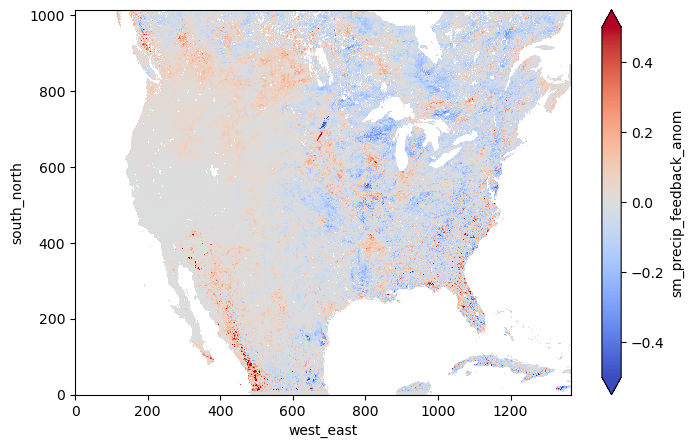

In [39]:
fig=plt.figure(figsize=(8,5))
FI_mag_JJA.plot(vmin=-0.5,vmax=0.5,cmap='coolwarm')
plt.savefig('SM_P_mag_feedback_2020JJA_CONUS404_rmPrcp.png',bbox_inches='tight',dpi=400)

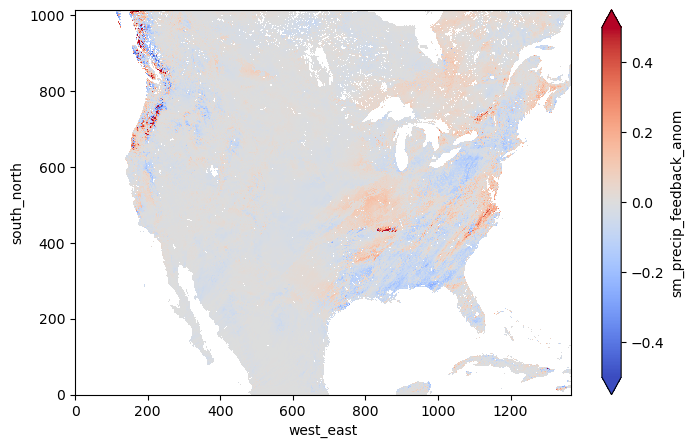

In [44]:
fig=plt.figure(figsize=(8,5))
FI_mag_DJF.plot(vmin=-0.5,vmax=0.5,cmap='coolwarm')
plt.savefig('SM_P_mag_feedback_2020DJF_CONUS404_rmPrcp.png',bbox_inches='tight',dpi=400)

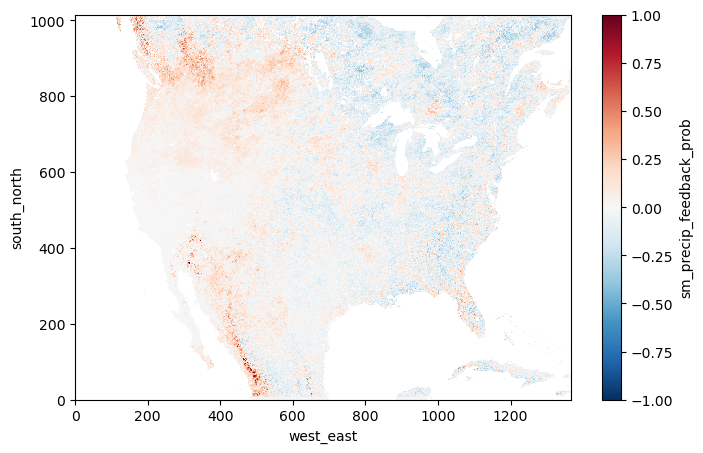

In [40]:
fig=plt.figure(figsize=(8,5))
FI_prob_JJA.plot()
plt.savefig('SM_P_prob_feedback_2020JJA_CONUS404_rmPrcp.png',bbox_inches='tight',dpi=400)

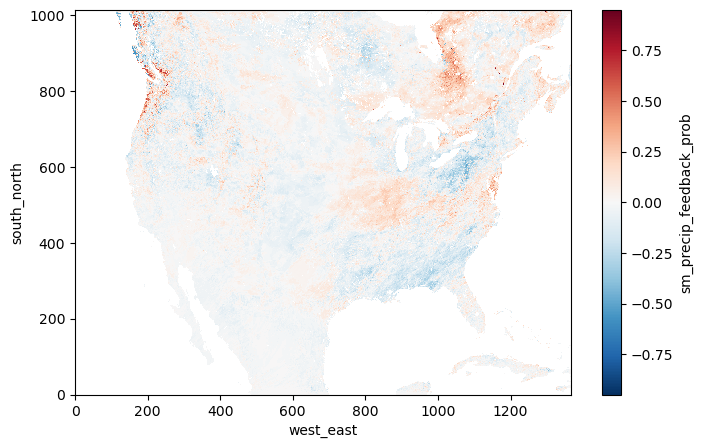

In [45]:
fig=plt.figure(figsize=(8,5))
FI_prob_DJF.plot()
plt.savefig('SM_P_prob_feedback_2020DJF_CONUS404_rmPrcp.png',bbox_inches='tight',dpi=400)